In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

import causal_ccm as cccm
from pyEDM import *

from time import process_time

from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops
from scipy.stats import pearsonr

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [2]:
def shadow_manifold(X):
    L = 646
    X = X[:L] # make sure we cut at L
    M = {t:[] for t in range((E-1) * tau, L)} # shadow manifold
    for t in range((E-1) * tau, L):
        x_lag = [] # lagged values
        for t2 in range(0, E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
            x_lag.append(X[t-t2*tau])            
        M[t] = x_lag
    return(M)

def get_distances(Mx):
    """
    Args
        Mx: The shadow manifold from X
    Returns
        t_steps: timesteps
        dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
    """

    # we extract the time indices and vectors from the manifold Mx
    # we just want to be safe and convert the dictionary to a tuple (time, vector)
    # to preserve the time inds when we separate them
    t_vec = [(k, v) for k,v in Mx.items()]
    t_steps = np.array([i[0] for i in t_vec])
    vecs = np.array([i[1] for i in t_vec])
    dists = distance.cdist(vecs, vecs)    
    return(t_steps, dists)

def get_nearest_distances(t, t_steps, dists):
    """
    Args:
        t: timestep of vector whose nearest neighbors we want to compute
        t_teps: time steps of all vectors in Mx, output of get_distances()
        dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
        E: embedding dimension of shadow manifold Mx 
    Returns:
        nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
        nearest_distances: array of distances corresponding to vectors closest to vector at time t
    """
    t_ind = np.where(t_steps == t) # get the index of time t
    dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
    
    # get top closest vectors
    nearest_inds = np.argsort(dist_t)[1:E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
    nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
    nearest_distances = dist_t[nearest_inds]  
    
    return nearest_timesteps, nearest_distances

In [6]:
path_to_ccm_results = './data/processed/'

In [7]:
sst_anoms = xr.open_dataset('./data/SST_anoms.nc')

In [8]:
swe_anoms_flist = np.sort(glob.glob('./data/snow_by_eco/*.nc'))
ccm_results_flist = np.sort(glob.glob(path_to_ccm_results+'*.nc'))

In [9]:
ccm_results_flist

array(['./data/processed/SLP_anoms.nc', './data/processed/SWE_anoms.nc',
       './data/processed/ccm_SLP_tau_1.nc',
       './data/processed/ccm_SLP_tau_3.nc',
       './data/processed/ccm_SLP_tau_6.nc',
       './data/processed/ccm_SST_tau_1.nc',
       './data/processed/ccm_SST_tau_3.nc',
       './data/processed/ccm_SST_tau_6.nc'], dtype='<U33')

In [10]:
pyedm_ccm_res = xr.open_dataset(ccm_results_flist[3])

In [11]:
mlon = pyedm_ccm_res.sel(eco_region='Sierra Nevada').rho.max(dim='lat').idxmax(dim='lon')
mlat = pyedm_ccm_res.sel(eco_region='Sierra Nevada').rho.max(dim='lon').idxmax(dim='lat')

mlon, mlat

(<xarray.DataArray 'lon' ()>
 array(272.5)
 Coordinates:
     eco_region  <U13 'Sierra Nevada',
 <xarray.DataArray 'lat' ()>
 array(-12.5)
 Coordinates:
     eco_region  <U13 'Sierra Nevada')

In [12]:
mlon = pyedm_ccm_res.sel(eco_region='Sierra Nevada').rho.min(dim='lat').idxmin(dim='lon')
mlat = pyedm_ccm_res.sel(eco_region='Sierra Nevada').rho.min(dim='lon').idxmin(dim='lat')

mlon, mlat

(<xarray.DataArray 'lon' ()>
 array(272.5)
 Coordinates:
     eco_region  <U13 'Sierra Nevada',
 <xarray.DataArray 'lat' ()>
 array(55.)
 Coordinates:
     eco_region  <U13 'Sierra Nevada')

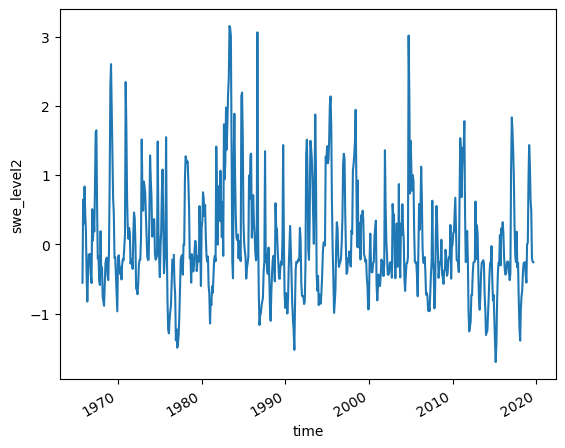

In [13]:
swe_anoms = xr.open_dataset(swe_anoms_flist[12])
swe_anom_sn = swe_anoms.mean(dim='sites').swe_level2
swe_anom_sn.plot()

In [14]:
sst_anoms.lon

<xarray.DataArray 'lon' (lon: 51)>
array([180., 182., 184., 186., 188., 190., 192., 194., 196., 198., 200., 202.,
       204., 206., 208., 210., 212., 214., 216., 218., 220., 222., 224., 226.,
       228., 230., 232., 234., 236., 238., 240., 242., 244., 246., 248., 250.,
       252., 254., 256., 258., 260., 262., 264., 266., 268., 270., 272., 274.,
       276., 278., 280.], dtype=float32)
Coordinates:
  * lon      (lon) float32 180.0 182.0 184.0 186.0 ... 274.0 276.0 278.0 280.0

In [15]:
np.mod(sst_anoms.lon - 180.0, 360.0) - 180.0

<xarray.DataArray 'lon' (lon: 51)>
array([-180., -178., -176., -174., -172., -170., -168., -166., -164.,
       -162., -160., -158., -156., -154., -152., -150., -148., -146.,
       -144., -142., -140., -138., -136., -134., -132., -130., -128.,
       -126., -124., -122., -120., -118., -116., -114., -112., -110.,
       -108., -106., -104., -102., -100.,  -98.,  -96.,  -94.,  -92.,
        -90.,  -88.,  -86.,  -84.,  -82.,  -80.], dtype=float32)
Coordinates:
  * lon      (lon) float32 180.0 182.0 184.0 186.0 ... 274.0 276.0 278.0 280.0

In [16]:
ssta_loc1 = sst_anoms.sel(lon=208, lat=22).sst # min
ssta_loc2 = sst_anoms.sel(lon=224, lat=42).sst # max

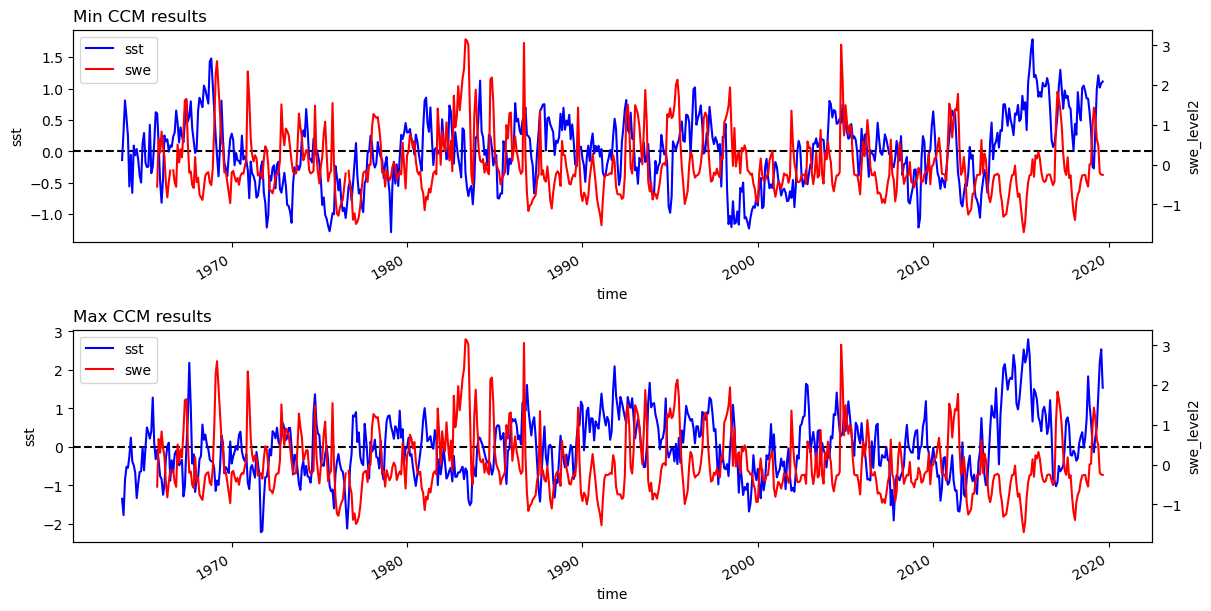

In [14]:
# compare time series
fig = plt.figure(figsize=(12,6), constrained_layout=True)
gs = fig.add_gridspec(2,1)

# ax_swe = fig.add_subplot(gs[0])
# ax_swe.axhline(y=0, color='k', ls='--')
# swe_anom_sn.plot(ax=ax_swe)

ax1 = fig.add_subplot(gs[0])
ax1.axhline(y=0, color='k', ls='--')
l1 = ssta_loc1.plot(ax=ax1, color='b', label='sst')
ax1_r = ax1.twinx()
l2 = swe_anom_sn.plot(ax=ax1_r, color='r', label='swe')
ax1.set_title('')
ax1.set_title('Min CCM results', loc='left')

# added these three lines
lns = l1+l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax2 = fig.add_subplot(gs[1])
ax2.axhline(y=0, color='k', ls='--')
l1 = ssta_loc2.plot(ax=ax2, color='b', label='sst')
ax2_r = ax2.twinx()
l2 = swe_anom_sn.plot(ax=ax2_r, color='r', label='swe')
ax2.set_title('')
ax2.set_title('Max CCM results', loc='left')
# added these three lines
lns = l1+l2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

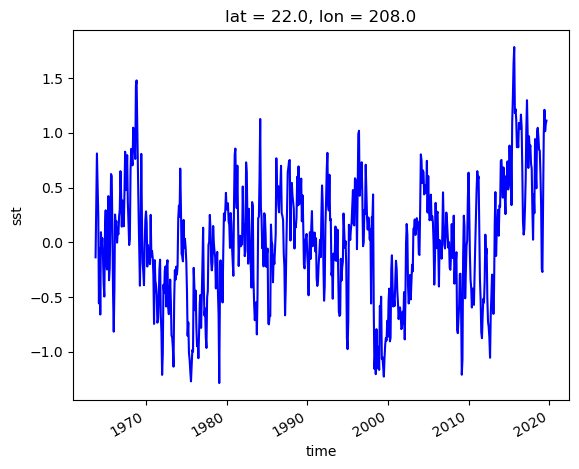

In [133]:
fig, ax = plt.subplots()
ssta_loc1.plot(ax=ax, color='b')
# ssta_loc2.plot(ax=ax, color='r')

## CCM on Min Pixel
### pyEDM

In [19]:
ssta_df = ssta_loc1.to_dataframe()
swea_df = swe_anom_sn.to_dataframe()

In [20]:
df = swea_df.join(ssta_df)
df = df.dropna()
df = df.reset_index()
df = df.drop(['lat', 'lon'], axis=1)

df['time'] = df['time'].map(lambda x: x.isoformat())

In [142]:
df

,time,swe_level2,sst
0,1965-10-01T00:00:00,-0.553304,0.603876
1,1965-11-01T00:00:00,0.645604,0.122574
2,1965-12-01T00:00:00,0.301817,-0.470299
3,1966-01-01T00:00:00,0.835638,-0.817520
4,1966-02-01T00:00:00,0.423662,-0.421007
...,...,...,...
641,2019-05-01T00:00:00,0.640542,0.991924
642,2019-06-01T00:00:00,0.481585,1.210438
643,2019-07-01T00:00:00,-0.201509,1.014502
644,2019-08-01T00:00:00,-0.250001,1.081446


In [21]:
L = len(df)
print(L)

646


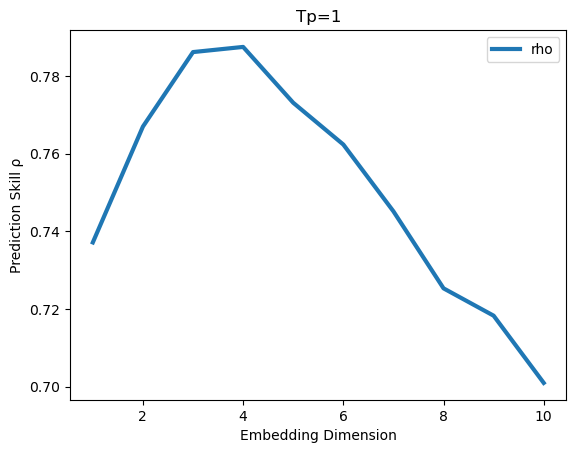

In [22]:
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

In [23]:
E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

4


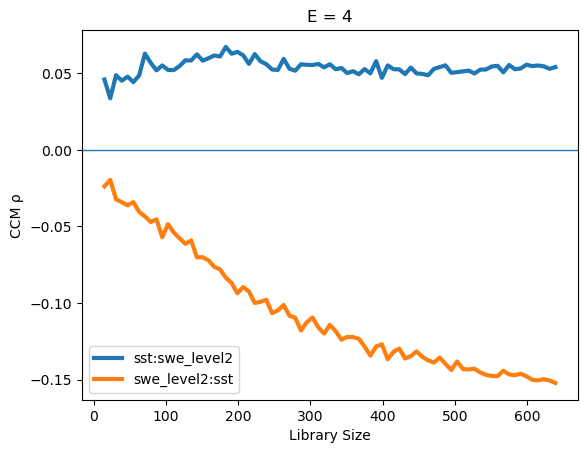

In [169]:
maxN = L - (E+1)

# look at orange line!
pyedm_res = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='sst',
               target='swe_level2',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

In [181]:
pyedm_res.FwdMap.FindNeighbors()
pyedm_res.FwdMap.Project()
pyedm_res.FwdMap.FormatProjection()

<Axes: xlabel='Time'>

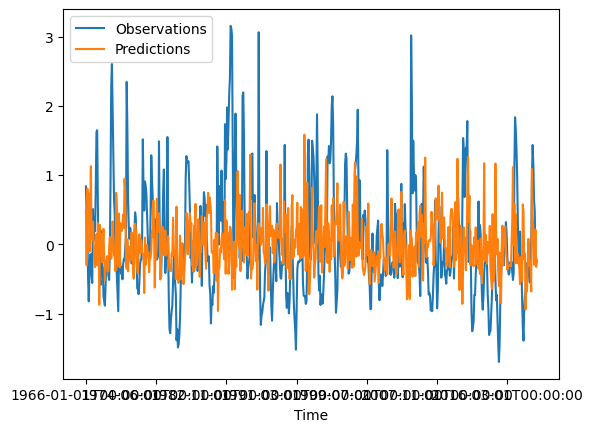

In [187]:
fig, ax = plt.subplots()
pyedm_res.FwdMap.Projection.plot(ax=ax, x='Time', y='Observations')
pyedm_res.FwdMap.Projection.plot(ax=ax, x='Time', y='Predictions')

In [175]:
# pyedm_res['swe_level2:sst'].iloc[-1]

S = pyedm_res.FwdMap

In [176]:
minDistances = S.knn_distances[:,0]

In [177]:
minDistances = np.fmax( minDistances, 1E-6 )

# Divide each column of N x k knn_distances by minDistances
scaledDistances = np.divide(S.knn_distances, minDistances[:,None])
weights         = np.exp( -scaledDistances )  # Npred x k
weightRowSum    = np.sum( weights, axis = 1 ) # Npred x 1


In [178]:
# Matrix of knn_neighbors + Tp defines library target values
knn_neighbors_Tp = S.knn_neighbors + 0      # Npred x k

libTargetValues = np.zeros( knn_neighbors_Tp.shape ) # Npred x k
for j in range( knn_neighbors_Tp.shape[1] ) :
    libTargetValues[ :, j ][ :, None ] = \
        S.targetVec[ knn_neighbors_Tp[ :, j ] ]
# Code from Simplex:Project ----------------------------------

# Projection is average of weighted knn library target values
projection_ = np.sum( weights * libTargetValues,
                   axis = 1) / weightRowSum

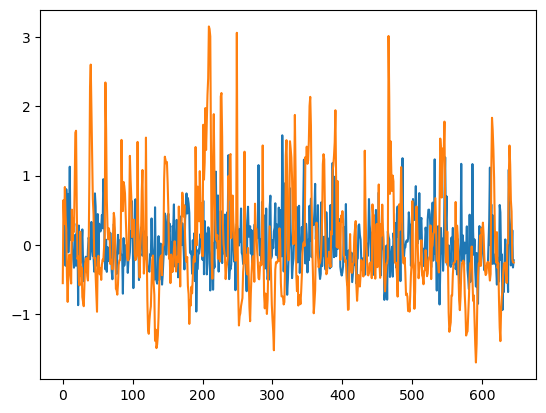

In [179]:
fig, ax = plt.subplots()
ax.plot(np.arange(3,646),projection_)
ax.plot(np.arange(646), df.swe_level2)
# ax.plot(np.arange(646), df.sst)

In [140]:
ssta_loc1

<xarray.DataArray 'sst' (time: 672)>
array([-0.138054,  0.315554,  0.811405, ...,  1.014502,  1.081446,  1.111946],
      dtype=float32)
Coordinates:
    lat      float32 22.0
    lon      float32 208.0
  * time     (time) datetime64[ns] 1963-10-01 1963-11-01 ... 2019-09-01

In [128]:
pyedm_res.FwdMap.projection

AttributeError: 'Simplex' object has no attribute 'projection'

In [102]:
pyedm_resFwdCM

AttributeError: 'CCM' object has no attribute 'FwdCM'

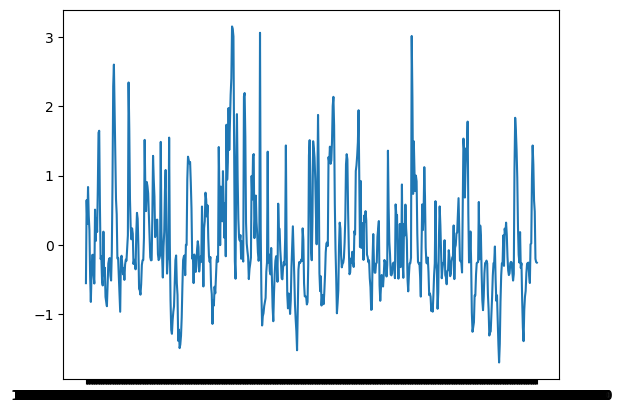

In [99]:
plt.plot(pyedm_res.FwdMap.allTime, pyedm_res.FwdMap.targetVec)

In [89]:
dir(pyedm_res)

['CrossMap',
 'CrossMapList',
 'Data',
 'E',
 'FwdMap',
 'PredictStats1',
 'PredictStats2',
 'Project',
 'RevMap',
 'Tp',
 'Validate',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'columns',
 'embedded',
 'exclusionRadius',
 'ignoreNan',
 'includeData',
 'knn',
 'lib',
 'libMeans',
 'libSizes',
 'name',
 'noTime',
 'pred',
 'sample',
 'seed',
 'target',
 'tau',
 'validLib',
 'verbose']

In [88]:
pyedm_res.Project

<bound method CCM.Project of <pyEDM.CCM.CCM object at 0x284b27190>>

### causal-ccm

In [23]:
tau = 1

In [24]:
X = df['sst']
Y = df['swe_level2']
E = 4
ccm1 = cccm.ccm(X, Y, tau, E, L)

In [25]:
X_lag, Y_lag = [], []
for t in range(1, len(X)):
    X_lag.append(X[t-tau])
    Y_lag.append(Y[t-tau])    
X_t, Y_t = X[1:], Y[1:] # remove first value

A, B = [(Y, X), (X, Y)][1]

Ma = shadow_manifold(A)
Mb = shadow_manifold(B)

t_steps_A, dists_A = get_distances(Ma) # for distances between points in manifold
t_steps_B, dists_B = get_distances(Mb) # for distances between points in manifold

timesteps = list(Ma.keys())
t = np.random.choice(timesteps, replace=False)
print(t)

Ma_t = Ma[t]
near_t_A, near_d_A = get_nearest_distances(t, t_steps_A, dists_A)

A_ts = []
A_lags = []

B_ts = []
B_lags = []
for i in range(E+1):
    # points on Ma
    A_ts.append(Ma[near_t_A[i]][0])
    A_lags.append(Ma[near_t_A[i]][1])

    # corresponding points on Mb
    B_ts.append(Mb[near_t_A[i]][0])
    B_lags.append(Mb[near_t_A[i]][1])
print(near_t_A)

545
[251 281 584 363 468]


In [26]:
ssta_loc1.isel(time=near_t_A)

<xarray.DataArray 'sst' (time: 5)>
[5 values with dtype=float32]
Coordinates:
    lat      float32 22.0
    lon      float32 208.0
  * time     (time) datetime64[ns] 1984-09-01 1987-03-01 ... 2002-10-01

In [27]:
ssta_loc1.isel(time=t)

<xarray.DataArray 'sst' ()>
[1 values with dtype=float32]
Coordinates:
    lat      float32 22.0
    lon      float32 208.0
    time     datetime64[ns] 2009-03-01

(-3.0, 3.0, -3.0, 3.0)

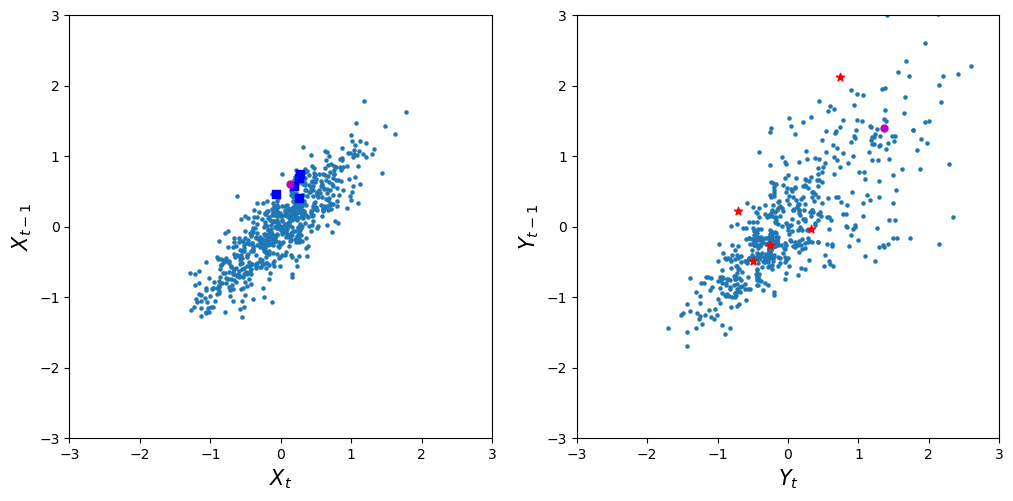

In [28]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].set_aspect('equal', adjustable='box')
axs[0].scatter(X_t, X_lag, s=5, label='$M_x$')
axs[0].plot(X[t], X[t-1], 'mo', markersize=5)
axs[0].scatter(A_ts, A_lags, c='b', marker='s')
# axs[0].plot([A_ts, B_ts], [A_lags, B_lags], c='r', linestyle=':')
axs[0].set_xlabel(r'$X_t$', size=15)
axs[0].set_ylabel(r'$X_{t-1}$', size=15)
axs[0].axis([-3,3,-3,3])

axs[1].set_aspect('equal', adjustable='box')
axs[1].plot(Y[t], Y[t-1], 'mo', markersize=5)
axs[1].scatter(Y_t, Y_lag, s=5, label='$M_x$')
axs[1].scatter(B_ts, B_lags, c='r', marker='*')
# axs[1].plot([A_ts, B_ts], [A_lags, B_lags], c='r', linestyle=':')
axs[1].set_xlabel(r'$Y_t$', size=15)
axs[1].set_ylabel(r'$Y_{t-1}$', size=15)
axs[1].axis([-3,3,-3,3])

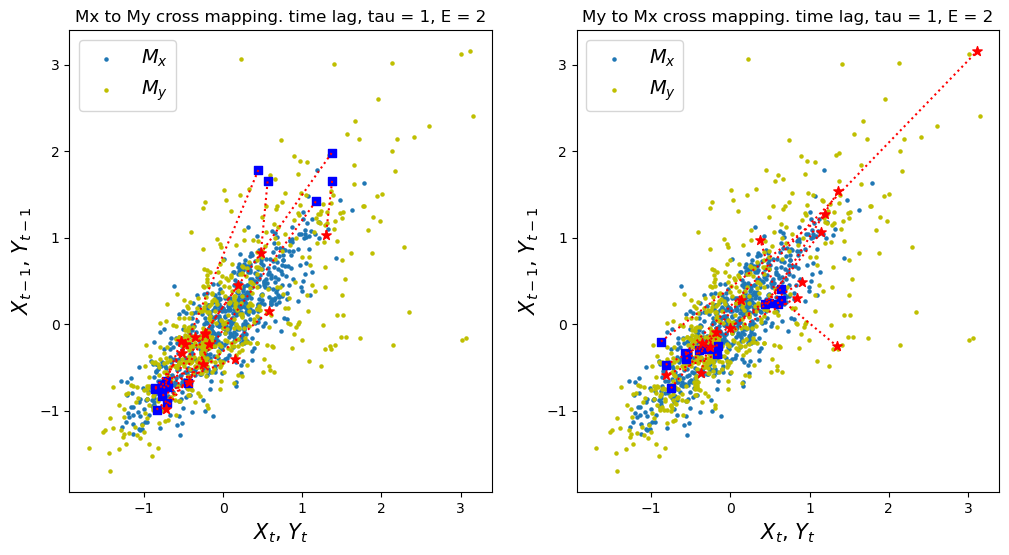

In [29]:
ccm1.visualize_cross_mapping()

In [30]:
corr_, p = ccm1.causality()
corr_, p

(-0.15272350536923965, 0.00010108489217226972)

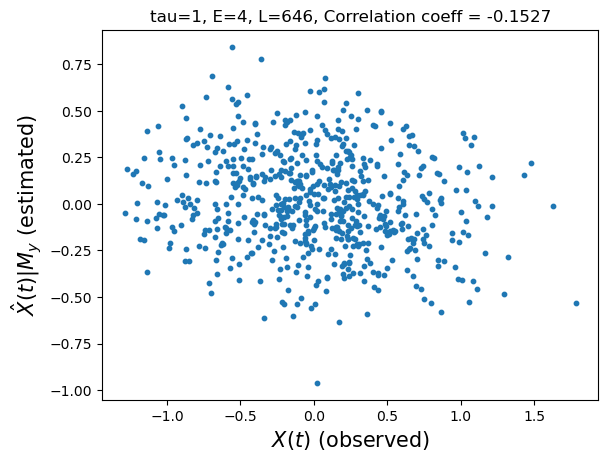

In [31]:
ccm1.plot_ccm_correls()

X->Y r -0.14 p value 0.0004
Y->X r 0.05 p value 0.1699


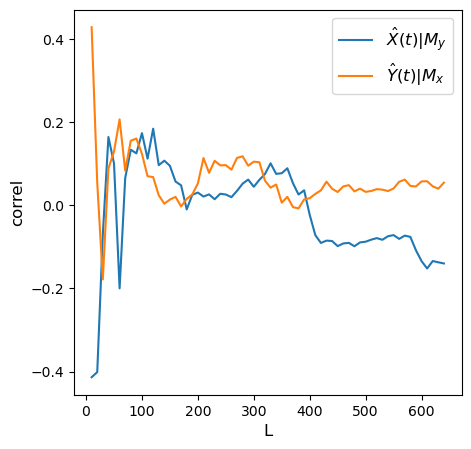

In [32]:
# checking convergence
# Looking at "convergence"
L_range = range(10, len(X), 10) # L values to test

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = cccm.ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = cccm.ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 4))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})
# plt.axis([0,700,-0.2,0.2])

# blue line matches with orange line

---
## CCM on Max Pixel
### pyEDM

In [33]:
ssta_df = ssta_loc2.to_dataframe()
swea_df = swe_anom_sn.to_dataframe()

In [34]:
df = swea_df.join(ssta_df)
df = df.dropna()
df = df.reset_index()
df = df.drop(['lat', 'lon'], axis=1)

df['time'] = df['time'].map(lambda x: x.isoformat())

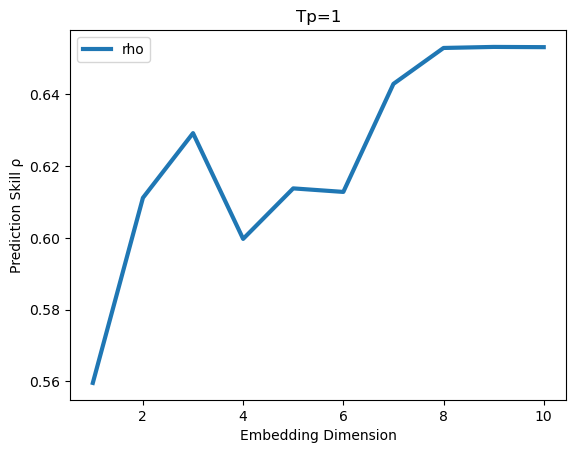

In [35]:
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

In [36]:
E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

9


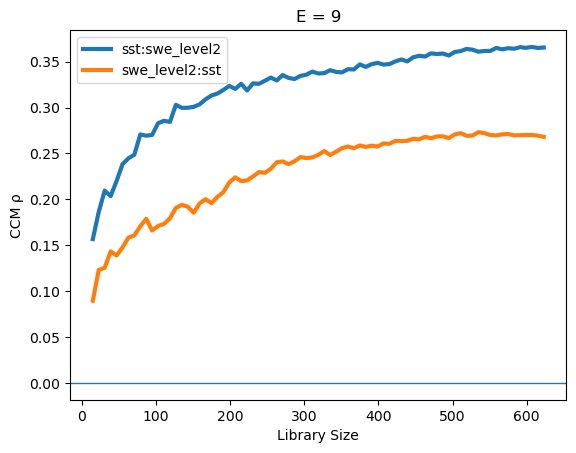

In [37]:
maxN = L - (E+1)

# look at orange line!
pyedm_res = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='sst',
               target='swe_level2',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True)

### causal-ccm

In [38]:
X = df['sst']
Y = df['swe_level2']
E = 9
ccm1 = cccm.ccm(X, Y, tau, E, L)

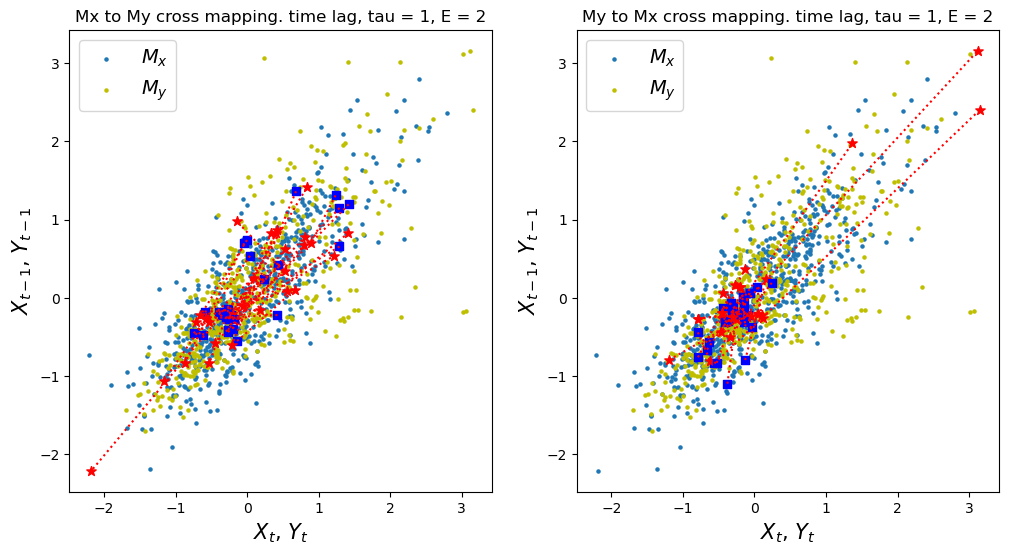

In [39]:
ccm1.visualize_cross_mapping()

In [40]:
corr_, p = ccm1.causality()
corr_, p

(0.266083758193657, 1.053902228849598e-11)

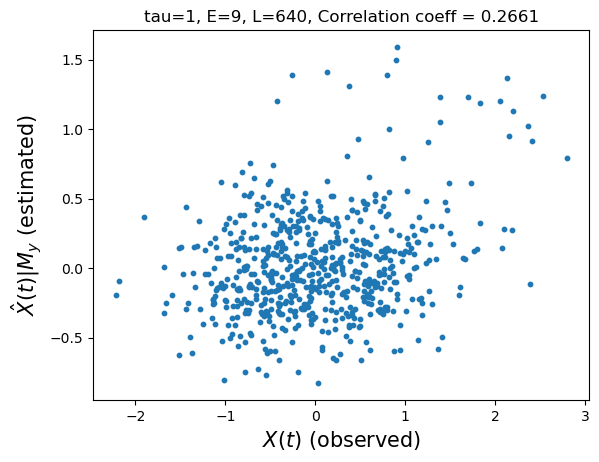

In [41]:
ccm1.plot_ccm_correls()

X->Y r 0.27 p value 0.0
Y->X r 0.37 p value 0.0


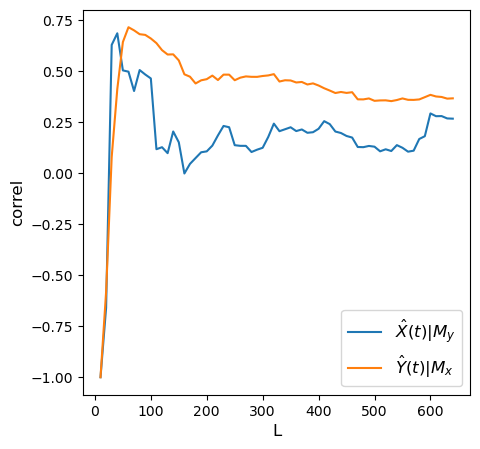

In [42]:
# checking convergence
# Looking at "convergence"
L_range = range(10, len(X), 10) # L values to test

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = cccm.ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = cccm.ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 4))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})
# plt.axis([0,700,-0.2,0.2])

# blue line matches with orange line

---

In [43]:
L

640

In [44]:
print(tau)


1


(-3.0, 3.0, -3.0, 3.0)

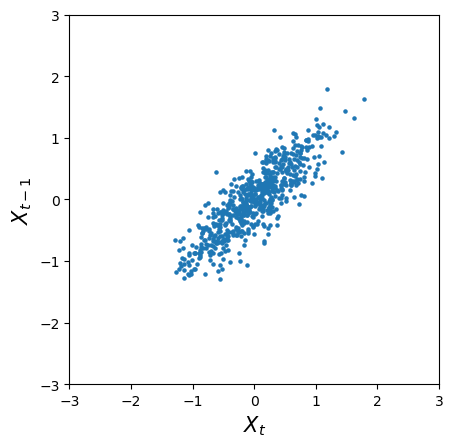

In [45]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.scatter(X_t, X_lag, s=5, label='$M_x$')
ax.set_xlabel(r'$X_t$', size=15)
ax.set_ylabel(r'$X_{t-1}$', size=15)
ax.axis([-3,3,-3,3])

(-3.0, 3.0, -3.0, 3.0)

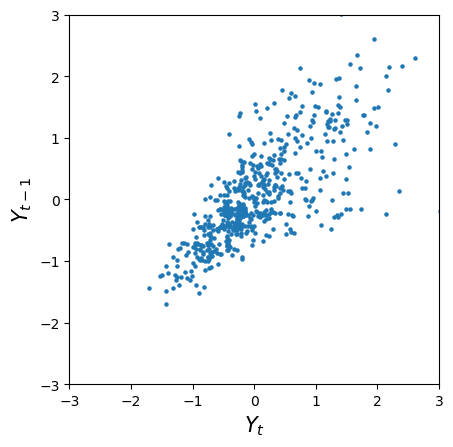

In [46]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.scatter(Y_t, Y_lag, s=5, label='$M_x$')
ax.set_xlabel(r'$Y_t$', size=15)
ax.set_ylabel(r'$Y_{t-1}$', size=15)
ax.axis([-3,3,-3,3])

In [47]:
X_lag, Y_lag = [], []
for t in range(1, len(X)):
    X_lag.append(X[t-tau])
    Y_lag.append(Y[t-tau])    
X_t, Y_t = X[1:], Y[1:] # remove first value

A, B = [(Y, X), (X, Y)][1]

Ma = shadow_manifold(A)
Mb = shadow_manifold(B)

t_steps_A, dists_A = get_distances(Ma) # for distances between points in manifold
t_steps_B, dists_B = get_distances(Mb) # for distances between points in manifold

timesteps = list(Ma.keys())
t = np.random.choice(timesteps, replace=False)

Ma_t = Ma[t]
near_t_A, near_d_A = get_nearest_distances(t, t_steps_A, dists_A)

A_ts = []
A_lags = []

B_ts = []
B_lags = []
for i in range(E+1):
    # points on Ma
    A_ts.append(Ma[near_t_A[i]][0])
    A_lags.append(Ma[near_t_A[i]][1])

    # corresponding points on Mb
    B_ts.append(Mb[near_t_A[i]][0])
    B_lags.append(Mb[near_t_A[i]][1])

print(t)
print(near_t_A)

281
[460 147 229 154 497 356  50 427 226 225]


In [48]:
ssta_loc2.isel(time=378)

<xarray.DataArray 'sst' ()>
[1 values with dtype=float32]
Coordinates:
    lat      float32 42.0
    lon      float32 224.0
    time     datetime64[ns] 1995-04-01

In [49]:
ssta_loc2.isel(time=near_t_A)

<xarray.DataArray 'sst' (time: 10)>
[10 values with dtype=float32]
Coordinates:
    lat      float32 42.0
    lon      float32 224.0
  * time     (time) datetime64[ns] 2002-02-01 1976-01-01 ... 1982-07-01

(-3.0, 3.0, -3.0, 3.0)

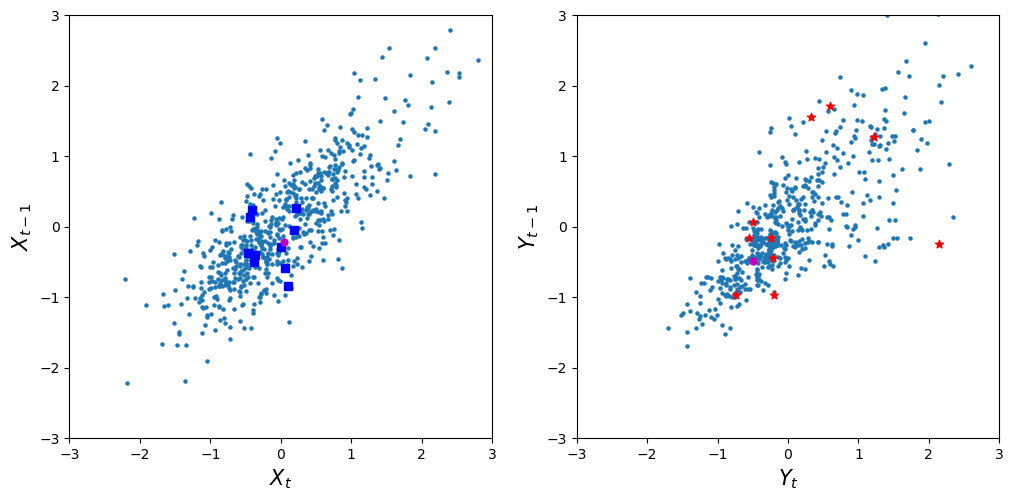

In [50]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].set_aspect('equal', adjustable='box')
axs[0].scatter(X_t, X_lag, s=5, label='$M_x$')
axs[0].plot(X[t], X[t-1], 'mo', markersize=5)
axs[0].scatter(A_ts, A_lags, c='b', marker='s')
# axs[0].plot([A_ts, B_ts], [A_lags, B_lags], c='r', linestyle=':')
axs[0].set_xlabel(r'$X_t$', size=15)
axs[0].set_ylabel(r'$X_{t-1}$', size=15)
axs[0].axis([-3,3,-3,3])

axs[1].set_aspect('equal', adjustable='box')
axs[1].plot(Y[t], Y[t-1], 'mo', markersize=5)
axs[1].scatter(Y_t, Y_lag, s=5, label='$M_x$')
axs[1].scatter(B_ts, B_lags, c='r', marker='*')
# axs[1].plot([A_ts, B_ts], [A_lags, B_lags], c='r', linestyle=':')
axs[1].set_xlabel(r'$Y_t$', size=15)
axs[1].set_ylabel(r'$Y_{t-1}$', size=15)
axs[1].axis([-3,3,-3,3])

---

In [226]:
t = np.linspace(0, 50 * np.pi, num=1000)
n = np.random.normal(scale=1, size=t.size)
n2 = np.random.normal(scale=1, size=t.size)

x = np.sin(t) + n
y = np.sin(t-np.pi) + n2

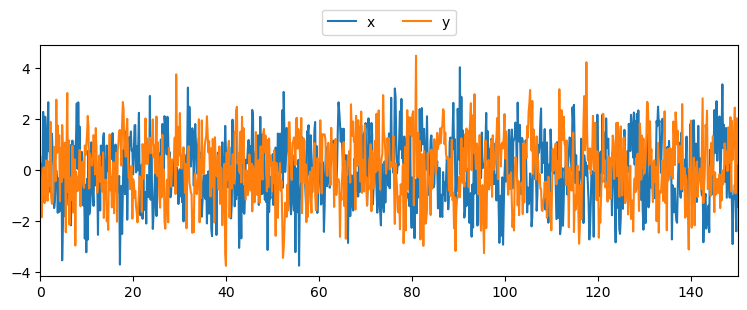

In [227]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(t,x, label='x')
ax.plot(t,y, label='y')
plt.xlim([0,150])
ax.legend(ncols=2, bbox_to_anchor=(0.5,1.1), loc='center')

In [228]:
test = pd.DataFrame({
    'X': x,
    'Y': y
})

In [241]:
XX = test['X']
YY = test['Y']

E = 8
tau = 1
L = 1000
ccm1 = cccm.ccm(XX, YY, tau, E, L)

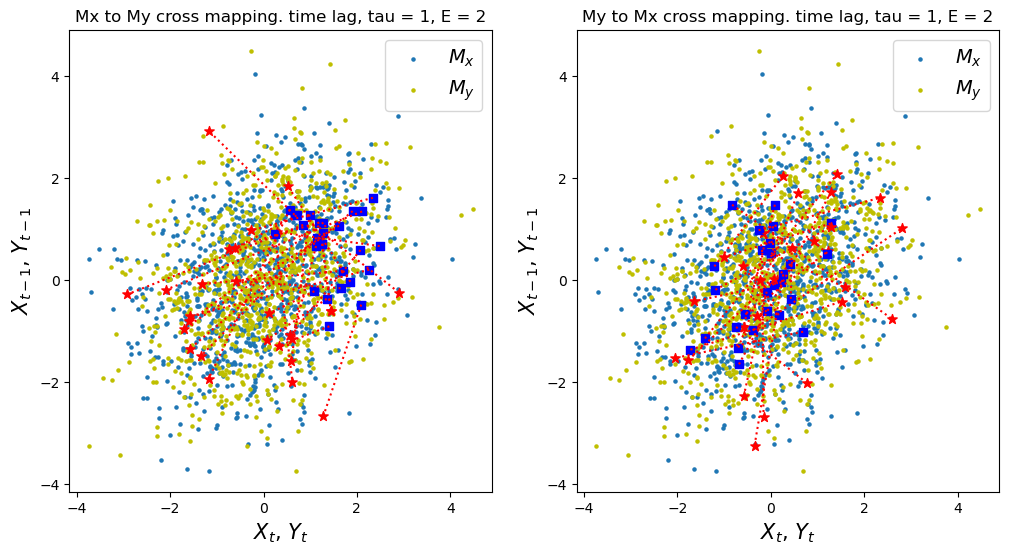

In [242]:
ccm1.visualize_cross_mapping()

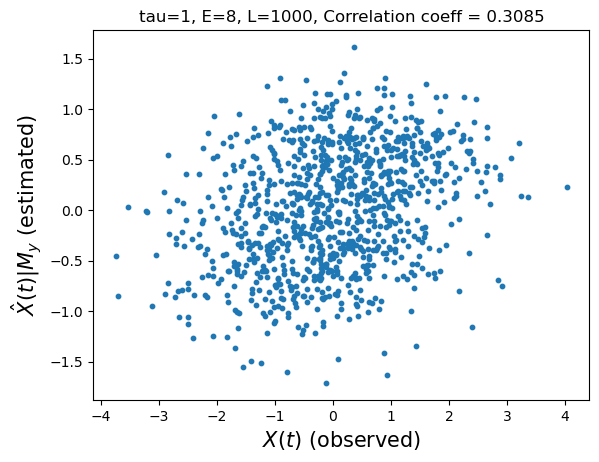

In [243]:
ccm1.plot_ccm_correls()

X->Y r 0.31 p value 0.0
Y->X r 0.4 p value 0.0


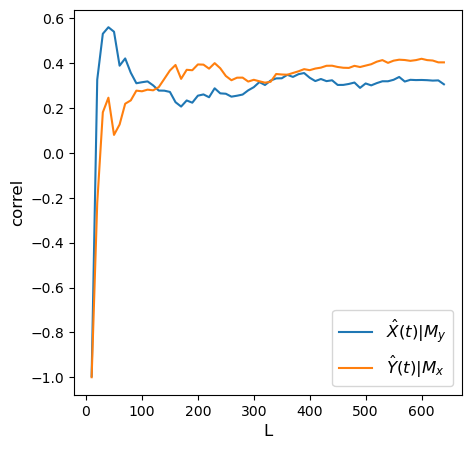

In [244]:
# checking convergence
# Looking at "convergence"
L_range = range(10, len(X), 10) # L values to test

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = cccm.ccm(XX, YY, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = cccm.ccm(YY, XX, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 4))    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 12})
# plt.axis([0,700,-0.2,0.2])

# blue line matches with orange line